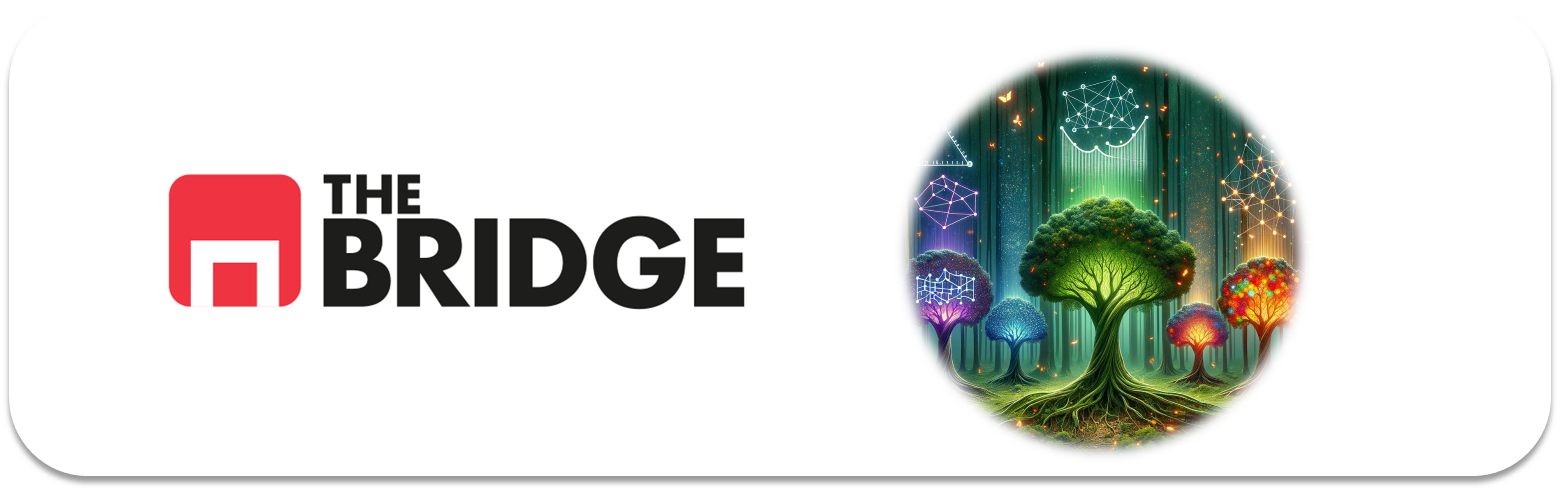

## PRACTICA OBLIGATORIA: **Ensamblado de modelos, bagging, boosting, random forest y gbts**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.datasets import load_diabetes
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import bootcampviztools as bt

np.random.seed(42)

### Descripción del dataset

El dataset de los Pima Indians Diabetes contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

### Características del Dataset

Las variables incluidas en el dataset son:

1. **Número de Embarazos**: Cantidad de veces embarazada.
2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
6. **Índice de Masa Corporal**: Peso en kg/(altura en m)^2.
7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
8. **Edad**: Edad en años.
9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente url y a continuación se proporciona una lista de nombres sugeridos para las columnas:


In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']

### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menos tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

In [3]:
# Cargamos el dataset y pegamos un vistazo a los datos

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv", header=None, names=names)
df

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### VISUALIZAMOS LOS DATOS

In [4]:
# Comprobamos si hay duplicados

df.duplicated(keep = False).value_counts()

False    768
Name: count, dtype: int64

*No hay duplicados. Pero OJO, no siempre los duplicados son malos, dependerá de negocio y la cantidad de variables que tengamos*

In [5]:
# Comprobamos la información de los datos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


*No hay valores nulos* \
*Todas las variables son numéricas por lo que no hay que transfomar nada*

In [6]:
df.describe()

,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


*Hay variables que tienen rangos muy amplios, por lo que habrá que ver si tenemos que escalar los datos para los modelos que utilicemos*

### ESCOGEMOS LA VARIABLE TARGET

En cuanto a la variable target ésta sería *"class"*. La comprobamos visualmente

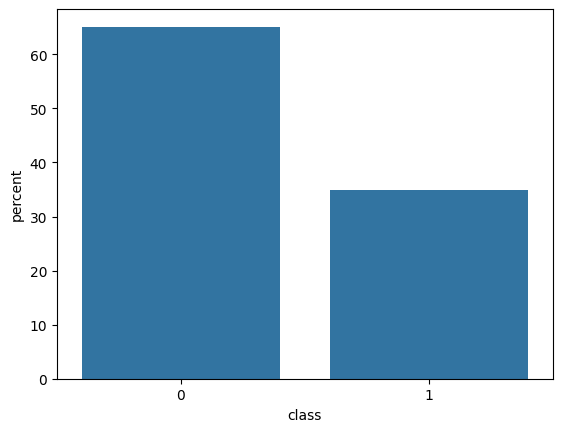

In [7]:
# Comprobamos la frecuencia de la variable target

sns.countplot(data=df, x="class", stat="percent");

*Hay cierto desbalanceo en los datos: 65% no desarrolló diabetes y 35% sí que lo desarrollaron* \
*Habría que tenerlo en cuenta a la hora de hacer el split entre train y test y estratificar. Se podría hacer por ejemplo un OVERSAMPLING, UNDERSAMPLING o SMOTE* \
*Nota: Para el árbol de decisión no haría falta aplicar las técnicas de la línea superior, podemos usar el hiperparámetro "class_weight" = "balanced" para que lo trate directamente el algoritmo. El modelo de regresión logística sí que lo necesitaría pero para nuestro ejercicio no lo vamos a aplicar*

### HACEMOS EL SPLIT ENTRE TRAIN Y TEST

In [8]:
# Dividimos entre train y test

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
# Comprobamos la frecuencia de "class" en los dataset de train y set, y así ver la estratificación

train_set["class"].value_counts(normalize = True)

class
0    0.653094
1    0.346906
Name: proportion, dtype: float64

*Ha quedado bastante desbalanceada la variable target en el train debido a que hay muy pocos datos de class = 1* 

In [10]:
# Definimos la variable target en una variable concreta

target = "class"

# Generamos las parejas X,y de train y test

X_train = train_set.drop(target, axis = 1)
y_train = train_set[target]
X_test = test_set.drop(target, axis = 1)
y_test = test_set[target]

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(614, 8)
(154, 8)
(614,)
(154,)


### HACEMOS UN MINI EDA DE LOS DATOS DE TRAIN

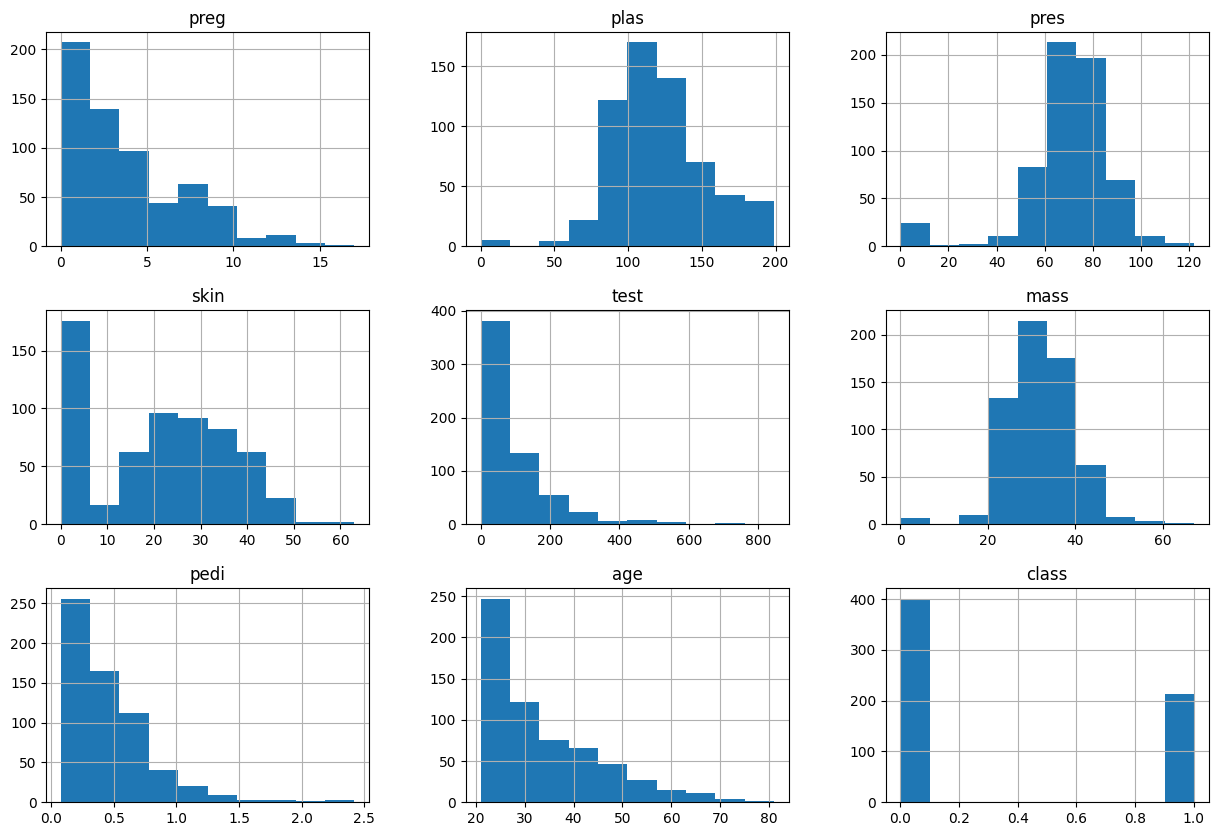

In [12]:
train_set.hist(figsize=(15, 10));

In [13]:
features_num = ["preg", "plas", "pres", "skin", "test", "mass", "pedi", "age", "class"]

In [14]:
bck_train_0 = train_set.copy()

In [15]:
train_set = bck_train_0

In [16]:
corr_matrix = train_set.corr(numeric_only= True)
corr_matrix_abs = corr_matrix["class"].abs().sort_values(ascending = False)
corr_matrix_abs

class    1.000000
plas     0.456117
mass     0.306335
age      0.280654
preg     0.207550
pedi     0.154560
test     0.108498
pres     0.082046
skin     0.057912
Name: class, dtype: float64

In [17]:
# Vamos a eliminar las columnas con correlación < 0.1 en train_set (luego habrá que hacerlo en X_test)

criterio = 0.1 # Fijamos un criterio para seleccionar nuestras features numéricas

features_num = corr_matrix_abs[corr_matrix_abs > criterio].index.to_list()
features_num.remove(target) # Quitamos el target

In [18]:
features_num

['plas', 'mass', 'age', 'preg', 'pedi', 'test']

In [19]:
# Comprobamos la colinealidad

criterio_col = 0.7
excluidas = []
corr_numeric = train_set[features_num].corr(numeric_only = True)

for col in features_num:
    print(f"Comprobando colinealidad de {col}")
    if col not in excluidas:
        for col_2, valor_corr in corr_numeric[col].items():
            print(f"\tComprobando {col} con {col_2}")
            if col != col_2 and col_2 in features_num:
                if np.abs(valor_corr) >= criterio_col:
                    print(f"\t\t--> {col} correla con {col_2} al {valor_corr:0.4f}, EXCLUIMOS {col_2} <--")
                    excluidas.append(col_2)
                else:
                    print(f"\t\t{col} correla con {col_2} al {valor_corr:0.4f}, mantenemos {col_2}")
            elif col == col_2:
                print("\t\tSon la misma variable, no comprobamos")
    
    elif col in excluidas:
        print(f"\tLa columna {col} ya ha sido excluida")

excluidas = list(set(excluidas))
print("\nLas variables a excluir son", excluidas)

Comprobando colinealidad de plas
	Comprobando plas con plas
		Son la misma variable, no comprobamos
	Comprobando plas con mass
		plas correla con mass al 0.2052, mantenemos mass
	Comprobando plas con age
		plas correla con age al 0.2707, mantenemos age
	Comprobando plas con preg
		plas correla con preg al 0.1425, mantenemos preg
	Comprobando plas con pedi
		plas correla con pedi al 0.1416, mantenemos pedi
	Comprobando plas con test
		plas correla con test al 0.3371, mantenemos test
Comprobando colinealidad de mass
	Comprobando mass con plas
		mass correla con plas al 0.2052, mantenemos plas
	Comprobando mass con mass
		Son la misma variable, no comprobamos
	Comprobando mass con age
		mass correla con age al 0.0045, mantenemos age
	Comprobando mass con preg
		mass correla con preg al 0.0272, mantenemos preg
	Comprobando mass con pedi
		mass correla con pedi al 0.1319, mantenemos pedi
	Comprobando mass con test
		mass correla con test al 0.1960, mantenemos test
Comprobando colinealidad d

<Axes: >

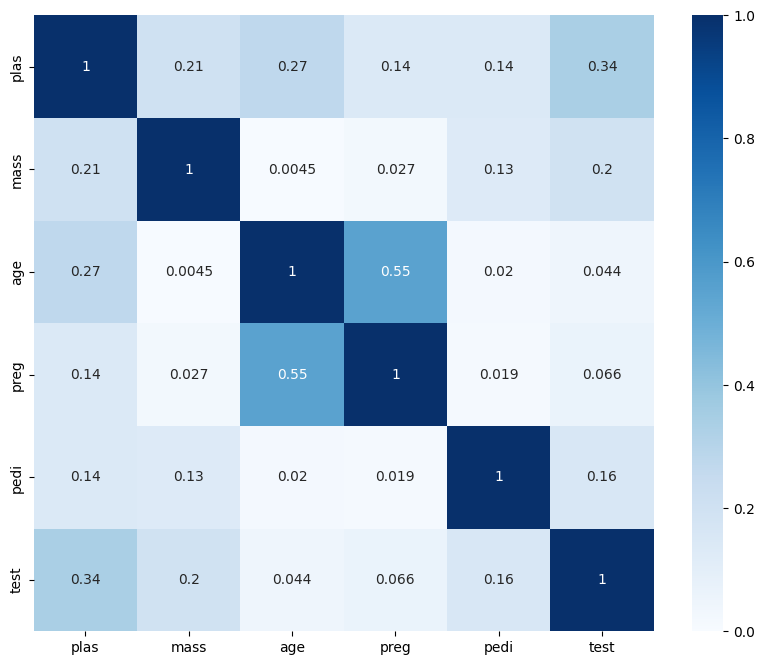

In [20]:
# Comprobamos las correlaciones entre las variables

plt.figure(figsize = (10,8))
sns.heatmap(np.abs(train_set[features_num].corr(numeric_only = True)), annot = True, cmap = "Blues", vmin=0, vmax=1)

In [21]:
def plot_histo_den(df, columns):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

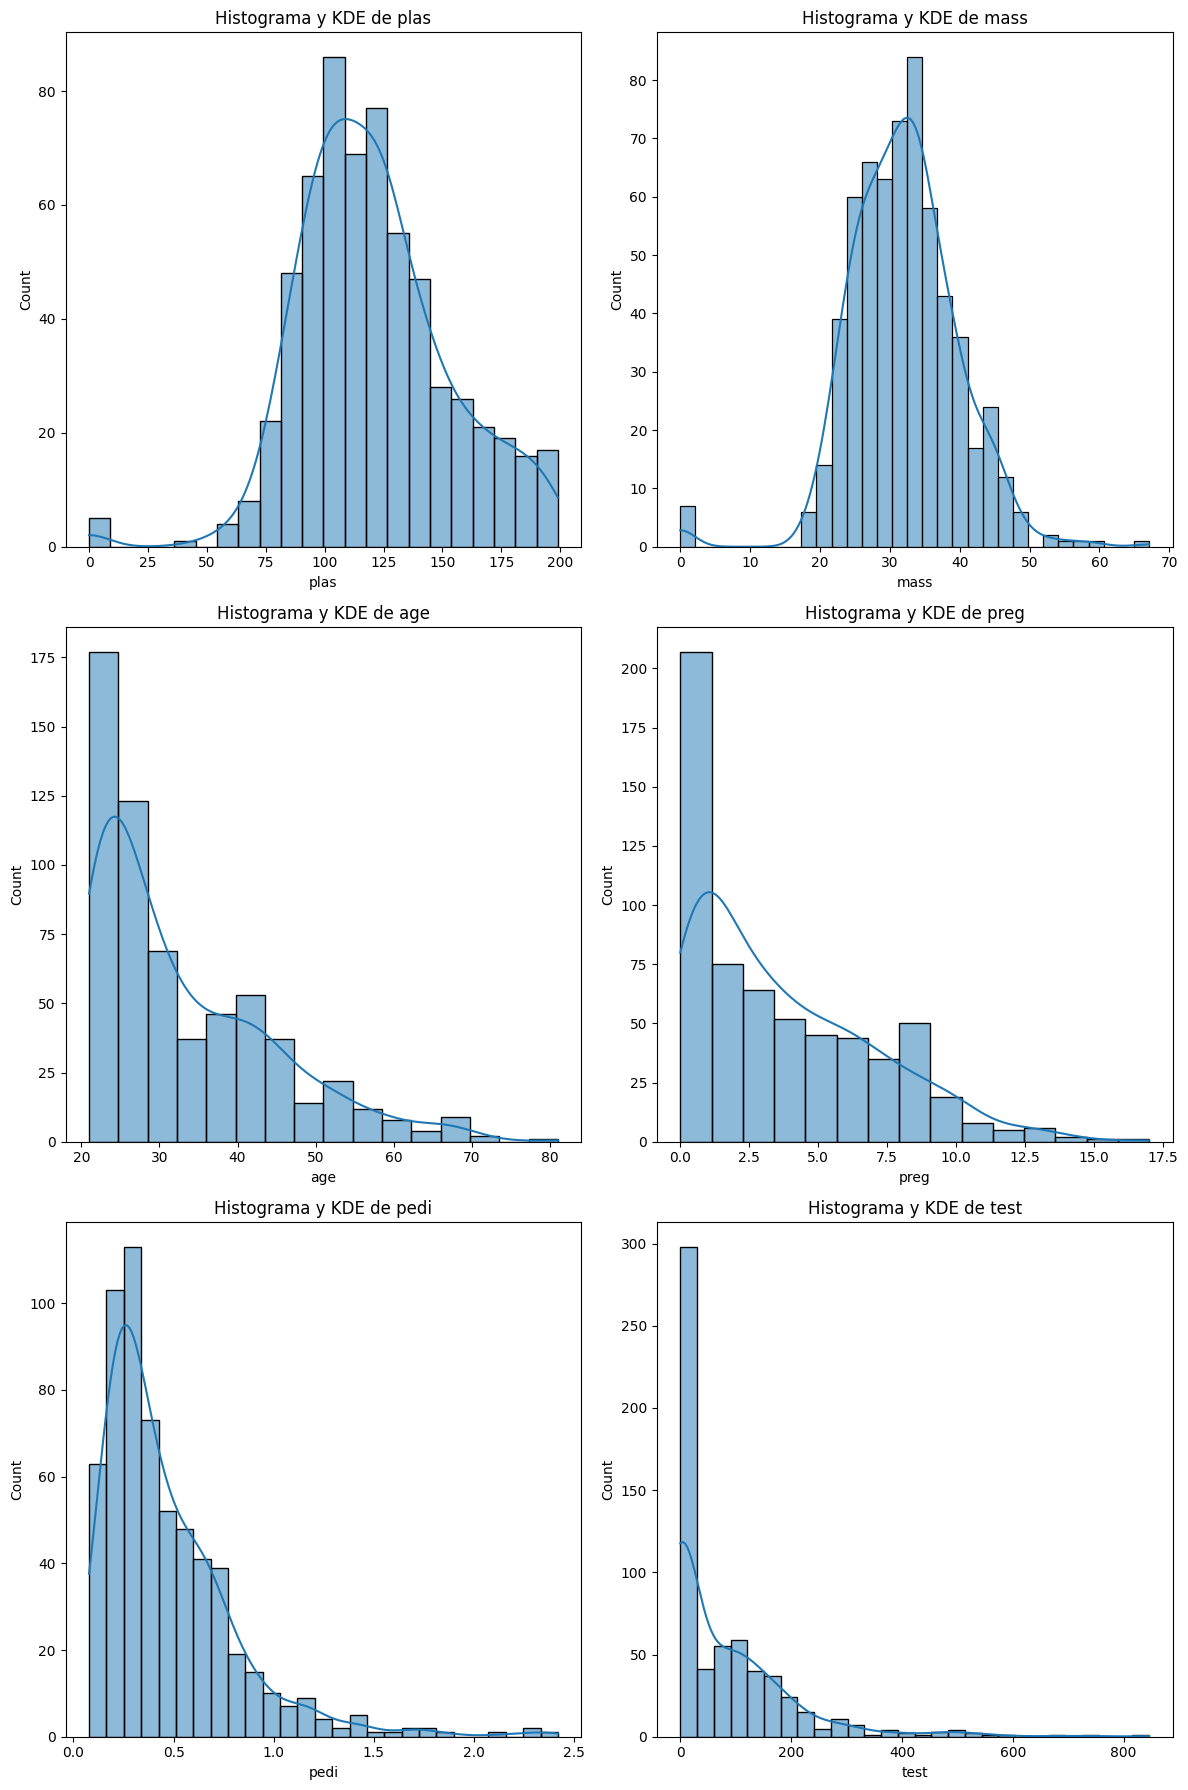

In [22]:
plot_histo_den(train_set, features_num)

In [23]:
# Comprobamos los valores = 0 de las diferentes variables

for i in features_num:
    print(f"Columna {i}: {sum(df[i] == 0)} valores igual a 0")

Columna plas: 5 valores igual a 0
Columna mass: 11 valores igual a 0
Columna age: 0 valores igual a 0
Columna preg: 111 valores igual a 0
Columna pedi: 0 valores igual a 0
Columna test: 374 valores igual a 0


*Vamos a aplicar el logaritmo a las variables "age", "preg", "pedi" y "test"*

In [24]:
bck_train_1 = train_set.copy()

In [25]:
train_set = bck_train_1

In [26]:
features_transform = ["age", "preg", "pedi", "test"]
features_log = []

# for feature in features_transform:
#     features_log.append(f"{feature}_log")
#     train_set[f"{feature}_log"] = train_set[feature].apply(np.log)

for feature in features_transform:
    features_log.append(f"{feature}_log")
    train_set[f"{feature}_log"] = np.log(train_set[feature]+1)

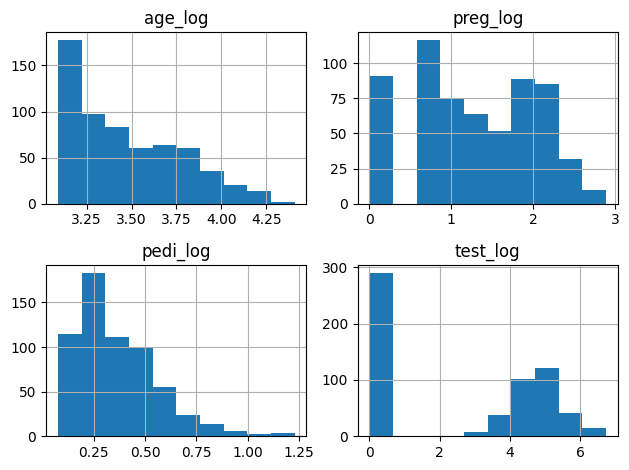

In [27]:
train_set[features_log].hist()
plt.tight_layout();

In [28]:
# Eliminamos las variables originales a las que ya hemos aplicado el logaritmo

features_num.remove("age")
features_num.remove("preg")
features_num.remove("pedi")
features_num.remove("test")

*Como vamos a utilizar bagging y boosting con árboles de decisión como modelo no es necesario escalar las variables numéricas*

In [29]:
train_set[features_num + features_log]

,plas,mass,age_log,preg_log,pedi_log,test_log
60,84,0.0,3.091042,1.098612,0.265436,0.000000
618,112,28.2,3.931826,2.302585,0.825052,0.000000
346,139,28.7,3.135494,0.693147,0.503197,4.430817
294,161,21.9,4.189655,0.000000,0.226338,0.000000
231,134,46.2,3.850148,1.945910,0.213497,5.916202
...,...,...,...,...,...,...
71,139,28.6,3.295837,1.791759,0.344299,4.948760
106,96,22.4,3.332205,0.693147,0.188138,0.000000
270,101,45.6,3.663562,2.397895,0.758935,0.000000
435,141,42.4,3.401197,0.000000,0.186480,0.000000


In [30]:
train_set[features_num + features_log].describe()

,plas,mass,age_log,preg_log,pedi_log,test_log
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,120.855049,31.983388,3.473330,1.289252,0.363103,2.540083
std,32.035057,7.740625,0.308390,0.768092,0.199482,2.455192
min,0.000000,0.000000,3.091042,0.000000,0.075107,0.000000
25%,100.000000,27.100000,3.218876,0.693147,0.216320,0.000000
50%,117.000000,32.000000,3.401197,1.386294,0.316633,3.772695
75%,139.000000,36.375000,3.713572,1.945910,0.478561,4.873282
max,199.000000,67.100000,4.406719,2.890372,1.229641,6.741701


In [31]:
train_set = train_set[features_num + features_log]

In [32]:
features_all = features_num + features_log

In [33]:
bck_train_2 = train_set.copy()

In [34]:
train_set = bck_train_2

### APLICAMOS TODO LO REALIZADO AL TEST_SET

In [35]:
y_test = test_set[target]

In [36]:
features_transform = ["age", "preg", "pedi", "test"]
features_log = []

for feature in features_transform:
    features_log.append(f"{feature}_log")
    test_set[f"{feature}_log"] = np.log(test_set[feature]+1)

In [37]:
test_set = test_set[features_num + features_log]

### CONSTRUIMOS LOS MODELOS

In [38]:
bck_train_3 = train_set.copy()

In [39]:
train_set = bck_train_3

In [40]:
# Ahora creamos las variables X,y para los datos de entrenamiento tras todo el trabajo previo

X = train_set.copy()
y = y_train

In [41]:
X_test = test_set

In [42]:
y_test = y_test

#### Bagging: RandomForestClassifier

Lo hacemos con las variables de train primero

In [43]:
# Construimos el modelo de bagging aplicando RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,
                                max_depth=4,
                                random_state=42)

rnd_clf.fit(X, y)

y_pred_rf = rnd_clf.predict(X)

In [44]:
def metrics_evaluation(model, X, y_target):
    y_pred = model.predict(X)
    ConfusionMatrixDisplay.from_predictions(y_target, y_pred)
    print(classification_report(y_target, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       401
           1       0.83      0.63      0.72       213

    accuracy                           0.83       614
   macro avg       0.83      0.78      0.80       614
weighted avg       0.83      0.83      0.82       614



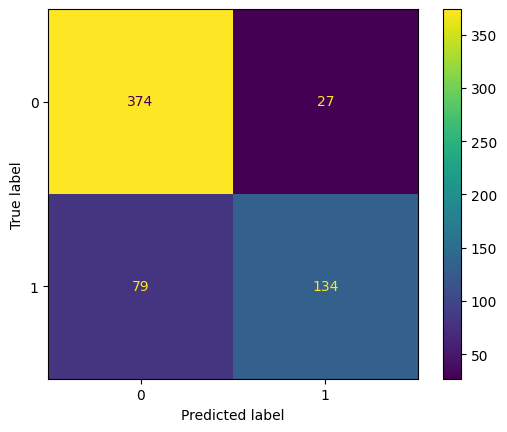

In [45]:
metrics_evaluation(rnd_clf, X, y)

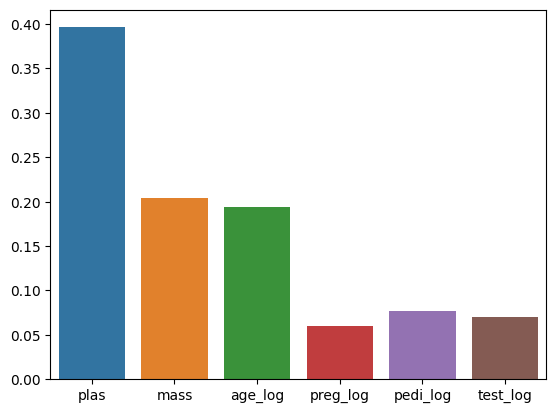

In [46]:
sns.barplot(x=features_all, y=rnd_clf.feature_importances_, hue = features_all);

#### Bagging: RandomForestClassifier

In [47]:
# Construimos el modelo de boosting aplicando AdaBoost

ada_clf = AdaBoostClassifier(n_estimators=200, random_state=42)

ada_clf.fit(X, y)

y_pred_ada = ada_clf.predict(X)

c:\Users\ancar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.91      0.91       401
           1       0.83      0.81      0.82       213

    accuracy                           0.88       614
   macro avg       0.86      0.86      0.86       614
weighted avg       0.88      0.88      0.88       614



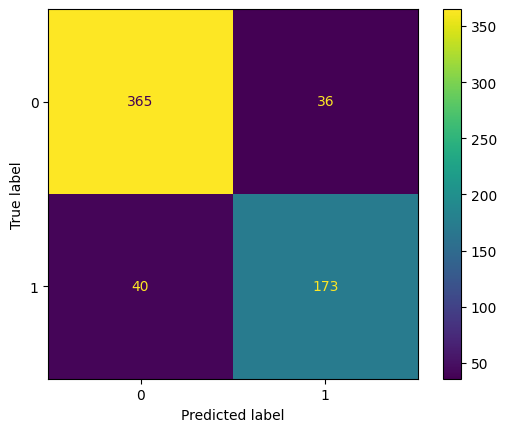

In [48]:
metrics_evaluation(ada_clf, X, y)

In [49]:
# Construimos el modelo de boosting aplicando GradientBoosting

gbc = GradientBoostingClassifier()

gbc.fit(X, y)

y_pred_gbc = gbc.predict(X)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       401
           1       0.92      0.83      0.87       213

    accuracy                           0.92       614
   macro avg       0.92      0.90      0.91       614
weighted avg       0.92      0.92      0.92       614



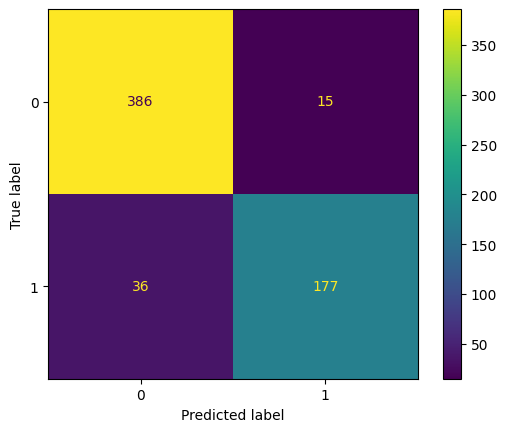

In [50]:
metrics_evaluation(gbc, X, y)

In [51]:
# Construimos el modelo de boosting aplicando XGBoost

xgb_clas = xgboost.XGBClassifier(random_state=42)

xgb_clas.fit(X, y)

y_pred_xgb = xgb_clas.predict(X)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



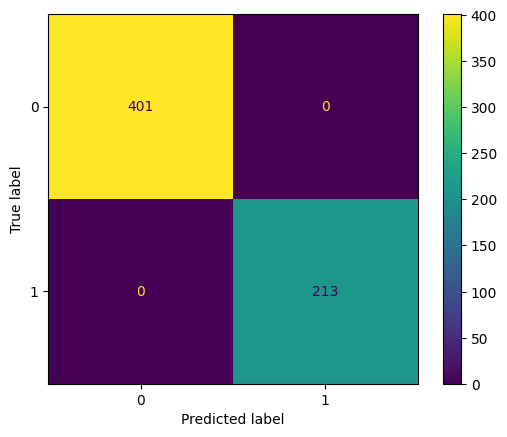

In [52]:
metrics_evaluation(xgb_clas, X, y)

*A priori, en estos modelos sin optimizar, el mejor de ellos sería el XGBoost (aunque todos lo valores están a 1, ha tenido que hacer overfitting)*

### OPTIMIZACIÓN DE HIPERPARÁMETROS

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



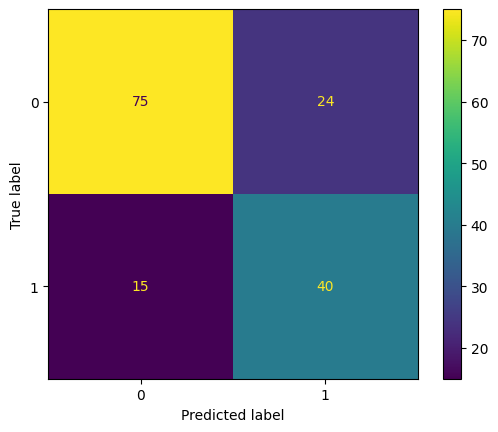

In [53]:
# Primero comprobamos como generaliza el modelo con los datos de test

metrics_evaluation(xgb_clas, X_test, y_test)

In [54]:
# Ahora optimizamos los hiperparámetros con RandomizeSearch

from xgboost import XGBClassifier

xgb_clf = XGBClassifier()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


xgb_grid.fit(X, y)
print("XGB best_score:", xgb_grid.best_score_)

XGB best_score: 0.7638370795472661


              precision    recall  f1-score   support

           0       0.78      0.76      0.77        99
           1       0.59      0.62      0.60        55

    accuracy                           0.71       154
   macro avg       0.68      0.69      0.69       154
weighted avg       0.71      0.71      0.71       154



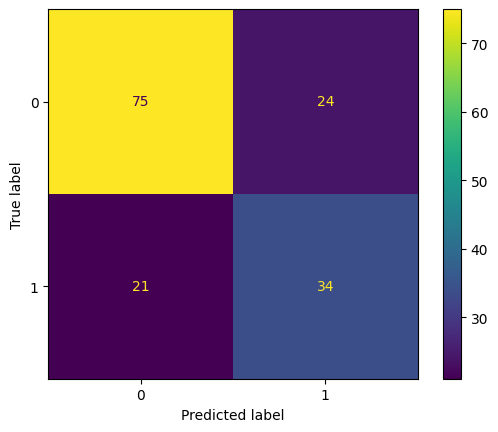

In [56]:
metrics_evaluation(xgb_grid, X_test, y_test)